<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/Synthetic_Data_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changes :

- Support for Syntehtic Data

Observations:

- The dataset is still called Balanced_SFEW, but it is actually synthetic_SFEW

Models:
- 14_03



## Cloning repository
Importing files regarding dataset, model, mains and utils

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 361 (delta 75), reused 67 (delta 32), pack-reused 209
Receiving objects: 100% (361/361), 22.13 MiB | 23.90 MiB/s, done.
Resolving deltas: 100% (189/189), done.


Installing dependencies

In [2]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

## Libraries and Initializations

In [3]:
# Installs from files
from da_cv_fer.data_config import DataConfig
# from da_cv_fer.ds_sfew import DatasetSFEW
# from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
from da_cv_fer.ds_expw_crop import EXPWCROP
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import *
from da_cv_fer.model_DANN import DANN
from da_cv_fer.model_DANN_Bespoke import DANNBespoke
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import *
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np


### Initializing configs

In [4]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

## SFEW Dataset

Creating dataloader objects.

It copies files from a google drive, unzips it and sets that for use

details: da_cv_fer.ds_sfew.DatasetSFEW

In [5]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
from torch.utils.data import DataLoader
# from torchvision.datasets import ImageFolder # for datasets
from pathlib import Path
import zipfile
import torchvision.transforms as transforms # transformation with respect to mean, std, 3 channel
from torchvision.datasets import ImageFolder # for datasets (reference: Sai's usage)
from torch.utils.data import Dataset
import torch
from PIL import Image
from torchvision.transforms import ToPILImage
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2
import os
import numpy as np

from facenet_pytorch import MTCNN

In [7]:
class OneHotSFEWCROPBALANCEDDataset(Dataset):
    def __init__(self, root, transform = None, crop_at_runtime = False) -> None:
        super().__init__()

        self.crop_at_runtime = crop_at_runtime
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if self.crop_at_runtime:
            self.mtcnn = MTCNN(image_size=224,device=self.device)#MTCNN(image_size=224).to(device=self.device)


        # dataconfig = DataConfig()
        self.transform = transform
        self.basic_transform = transforms.Compose([transforms.Resize((224, 224)),
                                                   transforms.ToTensor()])
        self.image_folder = ImageFolder(root, transform=self.basic_transform)
        self.class_labels = self.image_folder.classes
        self.to_pil = ToPILImage()
        # self.mean_ds = dataconfig.SFEW_mean_ds
        # self.std_dev_ds = dataconfig.SFEW_std_dev_ds
        self.tranforms_type = None

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        one_hot_label = torch.zeros(len(self.class_labels))
        one_hot_label[label]=1
        image_name = self.image_folder.imgs[idx][0]
        # print(f'  pixel range value = {torch.max(image.view(-1))} | {torch.min(image.view(-1))}')
        # print("image before \n", image)
        # self.to_pil(image).show()

        if image is None or (torch.all(image == 0).item() == 1):
            return torch.zeros((3,224,224)),one_hot_label, image_name

        if self.crop_at_runtime:
            image_pil = self.to_pil(image)

            # Get cropped and prewhitened image tensor
            img_cropped = self.mtcnn(image_pil,device=self.device)#.to(device=self.device)

            if img_cropped is None: # case where face is not detected
                if self.transform:
                    image = self.transform(image_pil)
                else:
                    image = self.basic_transform(image_pil)

                return image,one_hot_label, image_name
            else:# Rescale the tensor from the range [-1, 1] to [0, 1]
                image_tensor_rescaled = (img_cropped + 1) / 2
                # print(f'  pixel range value = {torch.max(image_tensor_rescaled.view(-1))} | {torch.min(image_tensor_rescaled.view(-1))}')
                # self.to_pil(image_tensor_rescaled).show()
                return image_tensor_rescaled, one_hot_label, image_name

        else:
            # print(f'  pixel range value before = {torch.max(image.view(-1))} | {torch.min(image.view(-1))}')

            if self.transform:
                image = self.transform(self.to_pil(image))
            else:
                image = self.basic_transform(self.to_pil(image))
            # print(f'  pixel range value = {torch.max(image.view(-1))} | {torch.min(image.view(-1))}')

            return image, one_hot_label, image_name



In [8]:
class DatasetSFEWCROPBALANCED():
    def __init__(self, crop_at_runtime=False) -> None:
        # 1. Download data
        self.crop_at_runtime = crop_at_runtime
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if not self.crop_at_runtime:
            self.mtcnn = MTCNN(image_size=224,device=self.device)#MTCNN(image_size=224).to(device='cpu') # offline changes are on CPU and not GPU
            # self.mtcnn = MTCNN(image_size=224) # offline changes are on CPU and not GPU


        dataconfig = DataConfig()
        print("balanced base path ", dataconfig.SFEW_BALANCED_BASE_PATH)
        self.BASE_PATH = dataconfig.SFEW_BALANCED_BASE_PATH
        self.origin_file_path = dataconfig.GDRIVE_SFEW_BALANCED_FILE_PATH
        self.EXTRACT_PATH = dataconfig.SFEW_BALANCED_EXTRACT_PATH
        self.SFEW_BALANCED_DATA_PATH = dataconfig.SFEW_BALANCED_DATA_PATH

        print("self.SFEW_BALANCED_DATA_PATH: ", self.SFEW_BALANCED_DATA_PATH)

        # self.ZIP_FILE_PATH = dataconfig.SFEW_ZIP_FILE_PATH
        self.labels = ['angry','disgust','fear','happy','neutral','sad','surprise']
        self.label_matrix = torch.eye(len(self.labels))

        self.dict_dataset = {'TRAIN_DIR' : Path(self.SFEW_BALANCED_DATA_PATH,'Train'),
                             'VAL_DIR' : Path(self.SFEW_BALANCED_DATA_PATH,'Val')}

        self.dict_crop_dataset = {'CROP_TRAIN_DIR' : Path(self.SFEW_BALANCED_DATA_PATH,'Train_Crop'),
                                  'CROP_VAL_DIR': Path(self.SFEW_BALANCED_DATA_PATH,'Val_Crop')}

        self.tranforms_type = None

        print(f' self.BASE_PATH -{self.BASE_PATH }, \n self.SFEW_BALANCED_DATA_PATH-{self.SFEW_BALANCED_DATA_PATH} ')

        # 2. Extract data # Not relevant as it is already extracted
        self.extract_dataset()

        # 3. Creating Dataset Object
        self.mean_ds = dataconfig.SFEW_mean_ds
        self.std_dev_ds = dataconfig.SFEW_std_dev_ds
        self.train_ds, self.val_ds = None, None # initialization
        self.train_ds, self.val_ds = self.get_dataset() #(self.mean_ds,self.std_dev_ds)

        # 4. Creating Dataloader Object
        self.BATCH_SIZE = dataconfig.SFEW_BALANCED_BATCH_SIZE
        self.cuda = dataconfig.cuda
        self.train_dl, self.val_dl = self.get_dataloader()
        return

    def extract_dataset(self):

        # Creating extract directory
        if not self.EXTRACT_PATH.exists():
            # Create the directory
            self.EXTRACT_PATH.mkdir(parents=True, exist_ok=True)
            print(f'Directory {self.EXTRACT_PATH} created successfully.')
        else:
            print(f'Directory {self.EXTRACT_PATH} already exists.')

        # Open the zip if files are not unzipped before
        if len(list(self.EXTRACT_PATH.glob("*"))) > 0:
            print(f"Files exist in {self.EXTRACT_PATH}, extraction not done")
        else:
            # copy the zip file, as nothing exists
            print(f"No files (including zip file) found in {self.EXTRACT_PATH}.Copying file")
            copy_file(self.origin_file_path,self.EXTRACT_PATH)

        # extract the files if not already present
        extract_zip_files(self.EXTRACT_PATH, self.EXTRACT_PATH)


        if not self.crop_at_runtime:
            flag_create_crop_contents = False
            for dir_name, dir_path in self.dict_crop_dataset.items():
                if not os.path.exists(dir_path): # check if the directories are already present under sfew
                    create_directory(dir_path) # creates if not there
                    flag_create_crop_contents = True

                else:
                    if is_directory_empty(dir_path): # check for contents inside them, if contents then exists else print that nothing in crop directory
                        print(f'**** {dir_name}/{dir_path} is empty***')
                        flag_create_crop_contents = True

            if flag_create_crop_contents:
                self.create_crop_contents()


        return

    def create_crop_contents(self):
        print("self.dict_dataset", self.dict_dataset)
        for dir_name, dir_path in self.dict_dataset.items():
            if 'TEST' in dir_name:
                pass # no treatment for test directory
            else:
                crop_dir_name = None
                for key in self.dict_crop_dataset:
                    if str(dir_name) in key:
                        crop_dir_name = f'CROP_{dir_name}'


                if crop_dir_name:
                    # for each file in dir_path, do the treatment and store in approrpiate directory
                    print("dir_path:", dir_path)

                    list_subdir = [ os.path.join(dir_path,subdir) for subdir in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,subdir))]
                    # print(list_subdir)
                    for subdir in list_subdir:
                        image_file_names = [f for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, f))]
                        target_dir = os.path.join(self.dict_crop_dataset[crop_dir_name],
                                                         os.path.basename(subdir))
                        if os.path.exists(target_dir):
                            print(f'***No files cropped for { os.path.basename(subdir)}, it is assumed to have files already')
                        else:
                            for image_name in image_file_names:
                                img = Image.open(os.path.join(subdir, image_name)).convert("RGB")
                                img_save_path = os.path.join(target_dir,
                                                            image_name)
                                # print(f'{os.path.join(subdir, image_name)} || {image_name} || {img_save_path}')
                                img_cropped = self.mtcnn(img, save_path = img_save_path) #.to(device=self.device)

                            print(f'{len(image_file_names)} cropped images created in {os.path.basename(subdir)}')

    def create_dataset(self, mean_ds = None, std_dev_ds=None):
        if mean_ds is None or std_dev_ds is None:
            # imagenet data values as default
            mean_ds = [0.485, 0.456, 0.406]
            std_dev_ds = [0.229, 0.224, 0.225]


        # Train Phase transformations
        #TODO: Use albumentations in later versions, first iteration does not include any transformations
        print(f'----------mean_ds = {mean_ds}, std_dev_ds = {std_dev_ds}----------')
        if self.tranforms_type == 'A': # Albumentations based
            sfew_train_transforms = A.Compose([
                A.Resize(224,224),# Resize the image to a specific size while maintaining the aspect ratio
                A.HorizontalFlip(p=0.7),# Apply horizontal flip with a probability of 50%
                A.Rotate(limit =15, p=0.7), # Apply a random rotation between +/- 7 degrees with 50% probability
                # A.GaussNoise( p=0.2), # Apply noise
                # A.RandomBrightnessContrast(p=0.5),# Random brigtness and Contrast
                # A.Normalize(mean=mean_ds, std=std_dev_ds),  # Normalize with calculated mean and std
                ToTensorV2(p=1.0) # Convert the image to a PyTorch tensor
            ])
        else:
            sfew_train_transforms = transforms.Compose([
                                        # transforms.CenterCrop(size = (224,224)),
                                        transforms.Resize((224, 224)),
                                        transforms.RandomApply([transforms.RandomResizedCrop(size=(224,224),scale=(0.8,1.0))],p=0.7),
                                        transforms.RandomApply([transforms.RandomHorizontalFlip(p=0.7)]),  # Horizontal flip with 70% probability
                                        transforms.RandomApply([transforms.RandomRotation(degrees=(-15, 15),fill=(1,))], p=0.7),  # Random rotation with 70% probability
                                        transforms.RandomApply([transforms.Grayscale(num_output_channels = 3)], p=0.3) , # gray scale
                                        transforms.RandomApply([v2.ColorJitter(brightness=.5, hue=.3)], p=0.3) , # color jitter
                                        transforms.RandomApply([v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))], p=0.3) , # gaussian blur
                                        transforms.RandomApply([v2.RandomAdjustSharpness(sharpness_factor=2)], p=0.3) , # sharpness
                                        transforms.RandomApply([v2.RandomAutocontrast()], p=0.3) , # autocontrast
                                        transforms.RandomApply([v2.RandomEqualize()], p=0.3) , # equalize
                                        cutout(mask_size=24,p=0.9,cutout_inside=False, mask_color=(255,255,255)) , # cut out white
                                        cutout(mask_size=24,p=0.9,cutout_inside=False, mask_color=(255,255,255)) , # cut out white
                                        cutout(mask_size=24,p=0.9,cutout_inside=False, mask_color=(255,255,255)) , # cut out white
                                        cutout(mask_size=24,p=0.9,cutout_inside=False, mask_color=(255,255,255)) , # cut out white
                                        cutout(mask_size=24,p=0.9,cutout_inside=False, mask_color=(0,0,0)), # cut out black
                                        cutout(mask_size=24,p=0.9,cutout_inside=False, mask_color=(0,0,0)), # cut out black
                                        cutout(mask_size=24,p=0.9,cutout_inside=False, mask_color=(0,0,0)), # cut out black
                                        cutout(mask_size=24,p=0.9,cutout_inside=False, mask_color=(0,0,0)), # cut out black
                                        transforms.ToTensor(),
                                        # transforms.Normalize(mean_ds, std_dev_ds)
                                        ])

        # Val Phase transformations
        if self.tranforms_type == 'A': # Albumentations based
            sfew_val_transforms=A.Compose([
                A.Resize(224,224),# Resize the image to a specific size while maintaining the aspect ratio
                # A.Normalize(mean=mean_ds, std=std_dev_ds),  # Normalize with calculated mean and std
                ToTensorV2() # Convert the image to a PyTorch tensor
            ])
        else:
            sfew_val_transforms = transforms.Compose([
                                                # transforms.CenterCrop(size = (224,224)),
                                                transforms.Resize((224, 224)),
                                                transforms.ToTensor(),
                                                # transforms.Normalize(mean_ds, std_dev_ds)
                                                ])
        if self.crop_at_runtime:
            sfew_train_ds = OneHotSFEWCROPBALANCEDDataset(root=self.dict_dataset['TRAIN_DIR'],
                                    transform=sfew_train_transforms,crop_at_runtime = True)
            sfew_val_ds = OneHotSFEWCROPBALANCEDDataset(root=self.dict_dataset['VAL_DIR'],
                                   transform=sfew_val_transforms, crop_at_runtime = True)
        else:
            sfew_train_ds = OneHotSFEWCROPBALANCEDDataset(root=self.dict_crop_dataset['CROP_TRAIN_DIR'],
                                    transform=sfew_train_transforms,
                                    crop_at_runtime = False)

            sfew_val_ds = OneHotSFEWCROPBALANCEDDataset(root=self.dict_crop_dataset['CROP_VAL_DIR'],
                                   transform=sfew_val_transforms,
                                   crop_at_runtime = False)




        return sfew_train_ds, sfew_val_ds

    def get_dataset(self, mean_ds = None, std_dev_ds=None):
        if self.train_ds is None and self.val_ds is None:
            if self.mean_ds is None and self.std_dev_ds is None:
               return self.create_dataset(mean_ds=self.mean_ds,std_dev_ds=self.std_dev_ds)
            else:
                return self.create_dataset(mean_ds=mean_ds,std_dev_ds=std_dev_ds)


        return self.train_ds, self.val_ds

    def get_dataloader(self,BATCH_SIZE=None):
        if BATCH_SIZE is not None:
            self.BATCH_SIZE = BATCH_SIZE

        dataloader_args = dict(shuffle=True, batch_size=self.BATCH_SIZE, num_workers=4, pin_memory=True) if self.cuda else dict(shuffle=True, batch_size=self.BATCH_SIZE)

        if self.train_ds is None or self.val_ds is None:
            # self.train_ds, self.val_ds = self.get_dataset(mean_ds=self.mean_ds,std_dev_ds=self.std_dev_ds)
            self.train_ds, self.val_ds = self.create_dataset()

        # train dataloader
        sfew_train_loader = DataLoader(self.train_ds, **dataloader_args)

        # val dataloader
        sfew_val_loader = DataLoader(self.val_ds, **dataloader_args)

        return sfew_train_loader, sfew_val_loader


In [9]:
# sfew = DatasetSFEW()
# sfew = DatasetSFEWCROP()
# sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
# print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')


sfew = DatasetSFEWCROPBALANCED(crop_at_runtime=False)
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')



balanced base path  dataset
self.SFEW_BALANCED_DATA_PATH:  dataset/balanced_SFEW/Balanced_SFEW
 self.BASE_PATH -dataset, 
 self.SFEW_BALANCED_DATA_PATH-dataset/balanced_SFEW/Balanced_SFEW 
Directory dataset/balanced_SFEW created successfully.
No files (including zip file) found in dataset/balanced_SFEW.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/Balanced_SFEW.zip to dataset/balanced_SFEW
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/Balanced_SFEW.zip to dataset/balanced_SFEW
Initiating extraction of dataset/balanced_SFEW/Balanced_SFEW.zip to dataset/balanced_SFEW
...completed for dataset/balanced_SFEW/Balanced_SFEW.zip
Directory created: dataset/balanced_SFEW/Balanced_SFEW/Train_Crop
Directory created: dataset/balanced_SFEW/Balanced_SFEW/Val_Crop
self.dict_dataset {'TRAIN_DIR': PosixPath('dataset/balanced_SFEW/Balanced_SFEW/Train'), 'VAL_DIR': PosixPath('dataset/balanced_SFEW/Balanced_SFEW/Val')}
dir_path: dataset/balanced_SFEW/

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# show_batch(sfew_train_loader,sfew.labels,4)

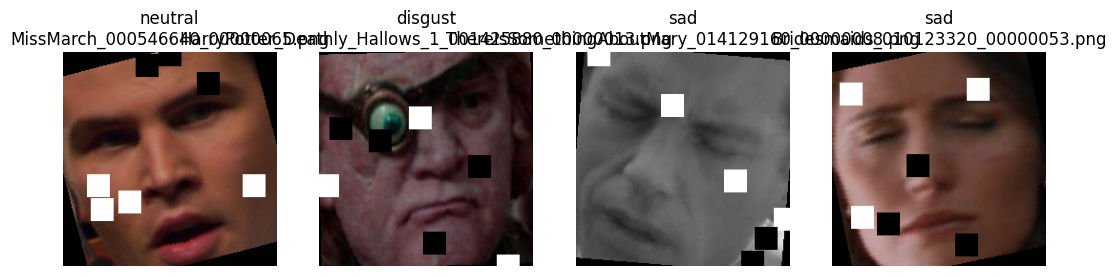

In [11]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

## EXPW Dataset
Creating dataset and dataloader objects.
Split into train and val.

`details: da_cv_fer.ds_expw.EXPW`
<br>
Please be patient, it takes around 3 minutes to download data set

In [12]:
# # expw_obj = EXPW()
# expw_obj = EXPWCROP()

# expw_train_ds, expw_val_ds = expw_obj.get_dataset()
# expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
# print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

In [13]:
# show_batch(expw_train_loader,expw_train_ds.labels,3)

In [14]:
# show_batch(expw_train_loader,expw_train_ds.labels,3, normalized = False)

## Creating Dataloaders for source and target

In [15]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']


In [16]:
# sfew_loader = {'name': 'sfew',
#                'train':sfew_train_loader,
#                'val':sfew_val_loader
#                }

# expw_loader = {'name': 'expw',
#                'train':expw_train_loader,
#                'val':expw_val_loader
#                }

# data_loader = {'source' : sfew_loader,
#                'target' : expw_loader}

# source_name = data_loader['source']['name']
# target_name = data_loader['target']['name']

## Initializing Model
details are present in `model_DANN`

In [17]:
model = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False, dropout = 0) #DANN(num_classes=7,backbone='mobilenet', dropout=0.1)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 99.5MB/s]

feature extractor backbone created using mobilenet model


In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)

cuda


In [19]:
model

DANNBespoke(
  (a): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): Sequential(
          (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Dropout2d(p=0, inplace=False)
        )
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): Sequential(
              (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): Dropout2d(p=0, inplace=False)
            )
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): Sequential(
            (0): BatchNorm2d(16, eps=1e-05, momentum=0.1

Running model for single run. checking output shapes

In [20]:
for usage, dict_data_loader in data_loader.items(): ## {'source' : sfew_loader,'target' : expw_loader}
    print('-'*80)
    print(usage)
    for k, v in dict_data_loader.items(): # {'name': 'sfew','train':sfew_train_loader,'val':sfew_val_loader}
      if k == 'name':
        print (f'--------{k} of dataset : {v}--------')
      else:
        print (f'   --------type : {k}--------')
        batch = next(iter(v)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
        images, labels = batch[0].to(device), batch[1].to(device)
        print( "Input:\n","Input Image: ",images.shape, ", labels: ",labels.shape)

        x_labels, x_domains, x_features = model(images) # forward pass
        print("Output:\n", "labels: ", x_labels.shape, ", domains: ",x_domains.shape, ", features: ", x_features.shape)


--------------------------------------------------------------------------------
source
--------name of dataset : sfew--------
   --------type : train--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) , domains:  torch.Size([16, 2]) , features:  torch.Size([16, 1280])
   --------type : val--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) , domains:  torch.Size([16, 2]) , features:  torch.Size([16, 1280])


Checking Misclassification images

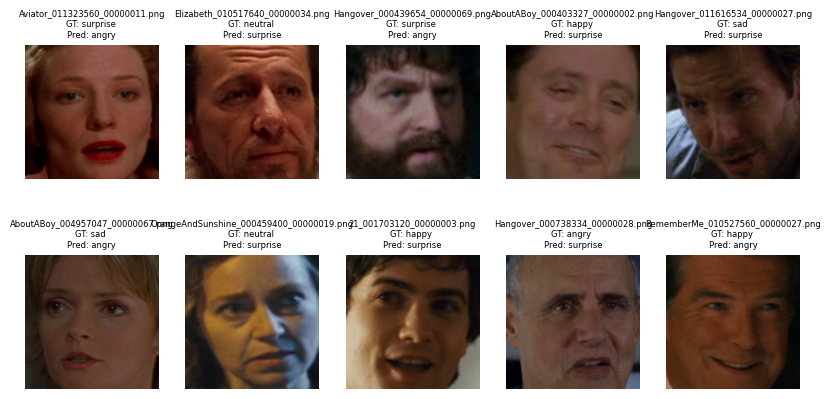

In [21]:
  list_misclassified_images = get_misclassified_images_list(model= model,
                                                            device = device,
                                                            test_loader = data_loader['source']['val'],
                                                            num_image = 10)
  plot_misclassified_images(list_misclassified_images,
                            labels = sfew.labels)

In [22]:
# #@title Weight Initialization

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       nn.init.xavier_normal_(m.weight)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       # nn.init.xavier_normal_(m.weight)
#       pass # not initialising Conv layers as they are pretrained
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight) # Linear layers are added on
#       nn.init.zeros_(m.bias)

## Non DANN: Training, Validating, Saving

### Early Stopping Scheduler - ReduceLRonPlateau

In [23]:
# def early_stopping_difference(list_loss: list, patience = 5, difference = 0.0003):
#   if len(list_loss) > patience:
#     reverse_list_loss = list_loss[::-1]
#     reverse_list_loss = reverse_list_loss[0:patience+1]
#     for index in range(0,len(reverse_list_loss)-1):
#       if abs(reverse_list_loss[index] - reverse_list_loss[index+1]) > difference:
#         return False
#     return True
#   else:
#     return False

Configuration towards execution

In [24]:
runconfig = RunConfig()
device = runconfig.device

non_dann_model = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False, dropout = 0) #DANN(num_classes=7, backbone = 'mobilenet')
non_dann_model = non_dann_model.to(device)
best_non_dann_model = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False, dropout = 0) #DANN(num_classes=7, backbone = 'mobilenet').to(device)
# non_dann_model.apply(weights_init) # initializing model, only linear layers

#learning rate
lr =  0.01 #float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
# EPOCHS = 5 #override
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9)

#optimizer with weight decay (L2 regularization)
# optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9, weight_decay= 0.0001)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

feature extractor backbone created using mobilenet model
feature extractor backbone created using mobilenet model
EPOCHS 150


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


------ Training started for Non DANN Model ---- 
starting LR : 0.01
EPOCH: 1  of  150
epoch = 1...in training function


Loss=2.090090274810791 Accuracy=221/1030(21.46%) Epoch Avg loss=0.12107303 LR=0.010000: 100%|██████████| 65/65 [00:10<00:00,  5.98it/s]


Test / Val: Average loss: 0.1230, Accuracy: 72/419 (17.18%)

last correct =72 | best correct = 0
Updated the best model with correct: 72



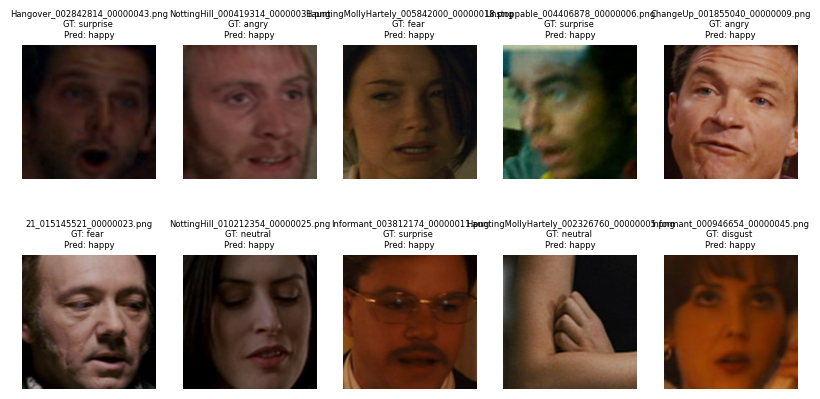

EPOCH: 2  of  150
epoch = 2...in training function


Loss=1.7814366817474365 Accuracy=240/1030(23.30%) Epoch Avg loss=0.11927145 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.36it/s]


Test / Val: Average loss: 0.1269, Accuracy: 72/419 (17.18%)

last correct =72 | best correct = 72
EPOCH: 3  of  150
epoch = 3...in training function


Loss=2.1491150856018066 Accuracy=231/1030(22.43%) Epoch Avg loss=0.11727303 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


Test / Val: Average loss: 0.1177, Accuracy: 103/419 (24.58%)

last correct =103 | best correct = 72
Updated the best model with correct: 103

EPOCH: 4  of  150
epoch = 4...in training function


Loss=1.2912285327911377 Accuracy=304/1030(29.51%) Epoch Avg loss=0.11226947 LR=0.010000: 100%|██████████| 65/65 [00:13<00:00,  4.74it/s]


Test / Val: Average loss: 0.1228, Accuracy: 84/419 (20.05%)

last correct =84 | best correct = 103
EPOCH: 5  of  150
epoch = 5...in training function


Loss=2.1206748485565186 Accuracy=320/1030(31.07%) Epoch Avg loss=0.10748975 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.25it/s]


Test / Val: Average loss: 0.1158, Accuracy: 115/419 (27.45%)

last correct =115 | best correct = 103
Updated the best model with correct: 115

EPOCH: 6  of  150
epoch = 6...in training function


Loss=1.9015569686889648 Accuracy=367/1030(35.63%) Epoch Avg loss=0.10585667 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]


Test / Val: Average loss: 0.1114, Accuracy: 130/419 (31.03%)

last correct =130 | best correct = 115
Updated the best model with correct: 130

EPOCH: 7  of  150
epoch = 7...in training function


Loss=1.4355915784835815 Accuracy=392/1030(38.06%) Epoch Avg loss=0.10133597 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.31it/s]


Test / Val: Average loss: 0.1096, Accuracy: 144/419 (34.37%)

last correct =144 | best correct = 130
Updated the best model with correct: 144

EPOCH: 8  of  150
epoch = 8...in training function


Loss=2.091458320617676 Accuracy=430/1030(41.75%) Epoch Avg loss=0.09819776 LR=0.010000: 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]


Test / Val: Average loss: 0.1117, Accuracy: 129/419 (30.79%)

last correct =129 | best correct = 144
EPOCH: 9  of  150
epoch = 9...in training function


Loss=1.5288991928100586 Accuracy=467/1030(45.34%) Epoch Avg loss=0.09360298 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.41it/s]


Test / Val: Average loss: 0.1054, Accuracy: 170/419 (40.57%)

last correct =170 | best correct = 144
Updated the best model with correct: 170

EPOCH: 10  of  150
epoch = 10...in training function


Loss=1.7238407135009766 Accuracy=479/1030(46.50%) Epoch Avg loss=0.09119893 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.40it/s]


Test / Val: Average loss: 0.1006, Accuracy: 183/419 (43.68%)

last correct =183 | best correct = 170
Updated the best model with correct: 183

EPOCH: 11  of  150
epoch = 11...in training function


Loss=0.8996697664260864 Accuracy=504/1030(48.93%) Epoch Avg loss=0.08689268 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.32it/s]


Test / Val: Average loss: 0.1037, Accuracy: 168/419 (40.10%)

last correct =168 | best correct = 183


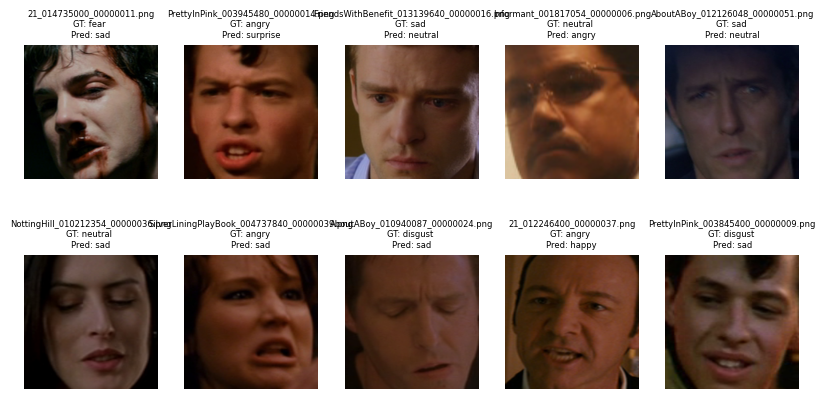

EPOCH: 12  of  150
epoch = 12...in training function


Loss=2.1867988109588623 Accuracy=535/1030(51.94%) Epoch Avg loss=0.08335824 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.24it/s]


Test / Val: Average loss: 0.1011, Accuracy: 184/419 (43.91%)

last correct =184 | best correct = 183
Updated the best model with correct: 184

EPOCH: 13  of  150
epoch = 13...in training function


Loss=1.367668867111206 Accuracy=565/1030(54.85%) Epoch Avg loss=0.07783643 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


Test / Val: Average loss: 0.1067, Accuracy: 168/419 (40.10%)

last correct =168 | best correct = 184
EPOCH: 14  of  150
epoch = 14...in training function


Loss=1.0778756141662598 Accuracy=542/1030(52.62%) Epoch Avg loss=0.07763816 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s]


Test / Val: Average loss: 0.1048, Accuracy: 163/419 (38.90%)

last correct =163 | best correct = 184
EPOCH: 15  of  150
epoch = 15...in training function


Loss=1.1026718616485596 Accuracy=588/1030(57.09%) Epoch Avg loss=0.07495434 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s]


Test / Val: Average loss: 0.1065, Accuracy: 189/419 (45.11%)

last correct =189 | best correct = 184
Updated the best model with correct: 189

EPOCH: 16  of  150
epoch = 16...in training function


Loss=0.8278385400772095 Accuracy=620/1030(60.19%) Epoch Avg loss=0.06996476 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.22it/s]


Test / Val: Average loss: 0.1093, Accuracy: 165/419 (39.38%)

last correct =165 | best correct = 189
EPOCH: 17  of  150
epoch = 17...in training function


Loss=1.2780208587646484 Accuracy=607/1030(58.93%) Epoch Avg loss=0.06925043 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.19it/s]


Test / Val: Average loss: 0.1097, Accuracy: 184/419 (43.91%)

last correct =184 | best correct = 189
EPOCH: 18  of  150
epoch = 18...in training function


Loss=1.9542014598846436 Accuracy=633/1030(61.46%) Epoch Avg loss=0.06827017 LR=0.010000: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]


Test / Val: Average loss: 0.1134, Accuracy: 176/419 (42.00%)

last correct =176 | best correct = 189
EPOCH: 19  of  150
epoch = 19...in training function


Loss=0.7276856303215027 Accuracy=706/1030(68.54%) Epoch Avg loss=0.05596042 LR=0.002000: 100%|██████████| 65/65 [00:14<00:00,  4.58it/s]


Test / Val: Average loss: 0.0957, Accuracy: 195/419 (46.54%)

last correct =195 | best correct = 189
Updated the best model with correct: 195

EPOCH: 20  of  150
epoch = 20...in training function


Loss=0.6074955463409424 Accuracy=749/1030(72.72%) Epoch Avg loss=0.04797865 LR=0.002000: 100%|██████████| 65/65 [00:12<00:00,  5.24it/s]


Test / Val: Average loss: 0.1022, Accuracy: 212/419 (50.60%)

last correct =212 | best correct = 195
Updated the best model with correct: 212

EPOCH: 21  of  150
epoch = 21...in training function


Loss=0.3978980481624603 Accuracy=761/1030(73.88%) Epoch Avg loss=0.04489335 LR=0.002000: 100%|██████████| 65/65 [00:12<00:00,  5.12it/s]


Test / Val: Average loss: 0.1003, Accuracy: 202/419 (48.21%)

last correct =202 | best correct = 212


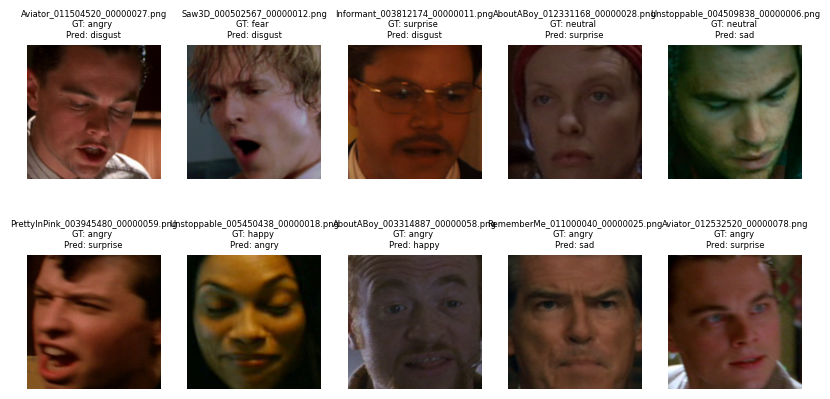

EPOCH: 22  of  150
epoch = 22...in training function


Loss=0.8116697669029236 Accuracy=792/1030(76.89%) Epoch Avg loss=0.04262164 LR=0.002000: 100%|██████████| 65/65 [00:11<00:00,  5.53it/s]


Test / Val: Average loss: 0.1044, Accuracy: 198/419 (47.26%)

last correct =198 | best correct = 212
EPOCH: 23  of  150
epoch = 23...in training function


Loss=0.6930162906646729 Accuracy=799/1030(77.57%) Epoch Avg loss=0.04079787 LR=0.002000: 100%|██████████| 65/65 [00:12<00:00,  5.40it/s]


Test / Val: Average loss: 0.1034, Accuracy: 208/419 (49.64%)

last correct =208 | best correct = 212
EPOCH: 24  of  150
epoch = 24...in training function


Loss=0.37781211733818054 Accuracy=807/1030(78.35%) Epoch Avg loss=0.03860641 LR=0.002000: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]


Test / Val: Average loss: 0.1144, Accuracy: 186/419 (44.39%)

last correct =186 | best correct = 212
EPOCH: 25  of  150
epoch = 25...in training function


Loss=0.15774670243263245 Accuracy=827/1030(80.29%) Epoch Avg loss=0.03584306 LR=0.002000: 100%|██████████| 65/65 [00:12<00:00,  5.13it/s]


Test / Val: Average loss: 0.1116, Accuracy: 210/419 (50.12%)

last correct =210 | best correct = 212
EPOCH: 26  of  150
epoch = 26...in training function


Loss=1.2098243236541748 Accuracy=837/1030(81.26%) Epoch Avg loss=0.03569184 LR=0.002000: 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


Test / Val: Average loss: 0.1183, Accuracy: 187/419 (44.63%)

last correct =187 | best correct = 212
EPOCH: 27  of  150
epoch = 27...in training function


Loss=0.7607640624046326 Accuracy=832/1030(80.78%) Epoch Avg loss=0.03424147 LR=0.002000: 100%|██████████| 65/65 [00:12<00:00,  5.03it/s]


Test / Val: Average loss: 0.1138, Accuracy: 203/419 (48.45%)

last correct =203 | best correct = 212
EPOCH: 28  of  150
epoch = 28...in training function


Loss=0.2564586102962494 Accuracy=833/1030(80.87%) Epoch Avg loss=0.03357814 LR=0.002000: 100%|██████████| 65/65 [00:12<00:00,  5.04it/s]


Test / Val: Average loss: 0.1153, Accuracy: 202/419 (48.21%)

last correct =202 | best correct = 212
EPOCH: 29  of  150
epoch = 29...in training function


Loss=0.8703436851501465 Accuracy=849/1030(82.43%) Epoch Avg loss=0.03198900 LR=0.002000: 100%|██████████| 65/65 [00:12<00:00,  5.03it/s]


Test / Val: Average loss: 0.1194, Accuracy: 180/419 (42.96%)

last correct =180 | best correct = 212
EPOCH: 30  of  150
epoch = 30...in training function


Loss=1.0216341018676758 Accuracy=870/1030(84.47%) Epoch Avg loss=0.02960340 LR=0.000400: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


Test / Val: Average loss: 0.1174, Accuracy: 192/419 (45.82%)

last correct =192 | best correct = 212
EPOCH: 31  of  150
epoch = 31...in training function


Loss=0.8662095069885254 Accuracy=892/1030(86.60%) Epoch Avg loss=0.02529437 LR=0.000400: 100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


Test / Val: Average loss: 0.1163, Accuracy: 189/419 (45.11%)

last correct =189 | best correct = 212


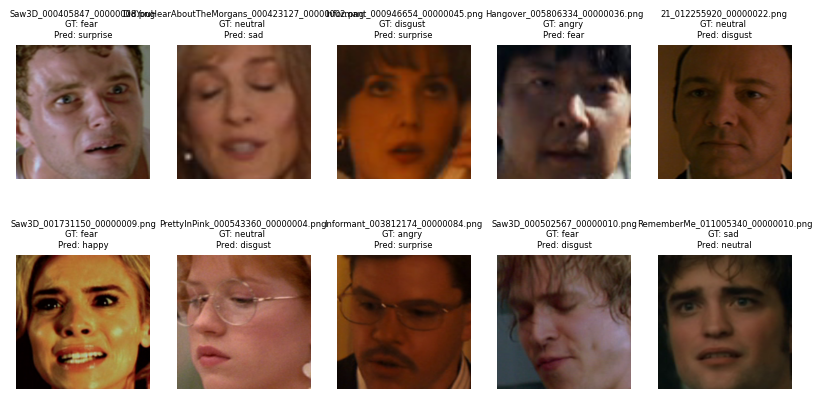

EPOCH: 32  of  150
epoch = 32...in training function


Loss=0.814741313457489 Accuracy=879/1030(85.34%) Epoch Avg loss=0.02752021 LR=0.000400: 100%|██████████| 65/65 [00:13<00:00,  4.86it/s]


Test / Val: Average loss: 0.1182, Accuracy: 192/419 (45.82%)

last correct =192 | best correct = 212
EPOCH: 33  of  150
epoch = 33...in training function


Loss=0.6593309640884399 Accuracy=899/1030(87.28%) Epoch Avg loss=0.02411648 LR=0.000400: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


Test / Val: Average loss: 0.1169, Accuracy: 199/419 (47.49%)

last correct =199 | best correct = 212
EPOCH: 34  of  150
epoch = 34...in training function


Loss=0.8364124298095703 Accuracy=901/1030(87.48%) Epoch Avg loss=0.02570246 LR=0.000400: 100%|██████████| 65/65 [00:14<00:00,  4.38it/s]


Test / Val: Average loss: 0.1185, Accuracy: 191/419 (45.58%)

last correct =191 | best correct = 212
EPOCH: 35  of  150
epoch = 35...in training function


Loss=0.7641024589538574 Accuracy=884/1030(85.83%) Epoch Avg loss=0.02484113 LR=0.000400: 100%|██████████| 65/65 [00:13<00:00,  4.88it/s]


Test / Val: Average loss: 0.1189, Accuracy: 198/419 (47.26%)

last correct =198 | best correct = 212
EPOCH: 36  of  150
epoch = 36...in training function


Loss=0.6003578901290894 Accuracy=901/1030(87.48%) Epoch Avg loss=0.02456290 LR=0.000400: 100%|██████████| 65/65 [00:13<00:00,  4.90it/s]


Test / Val: Average loss: 0.1224, Accuracy: 195/419 (46.54%)

last correct =195 | best correct = 212
EPOCH: 37  of  150
epoch = 37...in training function


Loss=0.14492404460906982 Accuracy=880/1030(85.44%) Epoch Avg loss=0.02457531 LR=0.000400: 100%|██████████| 65/65 [00:13<00:00,  4.89it/s]


Test / Val: Average loss: 0.1239, Accuracy: 188/419 (44.87%)

last correct =188 | best correct = 212
EPOCH: 38  of  150
epoch = 38...in training function


Loss=0.5032514929771423 Accuracy=894/1030(86.80%) Epoch Avg loss=0.02459617 LR=0.000400: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


Test / Val: Average loss: 0.1224, Accuracy: 193/419 (46.06%)

last correct =193 | best correct = 212
EPOCH: 39  of  150
epoch = 39...in training function


Loss=0.6016391515731812 Accuracy=913/1030(88.64%) Epoch Avg loss=0.02300293 LR=0.000080: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s]


Test / Val: Average loss: 0.1226, Accuracy: 192/419 (45.82%)

last correct =192 | best correct = 212
-------Early Stopping at epoch 39---
Best model loaded
Validation results with sfew
Test / Val: Average loss: 0.0979, Accuracy: 212/419 (50.60%)



In [25]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = non_dann_model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    # #Adding Scheduler #TODO: ADD SCHEDULER
    # scheduler.step(avg_epoch_loss) #applying scheduler on training loss

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(non_dann_model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    if early_stopping_difference(list_val_correct,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

    if early_stopping_difference(list_best_val_correct,
                                 patience = 2*early_stop_patience,
                                 difference= 0):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break



    ## showing misclassification images after every 10 epochs
    if epoch % 10 == 0:
      list_misclassified_images = get_misclassified_images_list(model= non_dann_model,
                                                                device = device,
                                                                test_loader = data_loader['source']['val'],
                                                                num_image = 10)
      plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  non_dann_model.load_state_dict(best_model_state)
  print('Best model loaded')


print(f'Validation results with {source_name}')

correct, test_loss_source = test_model(model= non_dann_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)

# print(f'Test results with {target_name}')
# correct, test_loss_target = test_model(model= non_dann_model, #best_non_dann_model, #non_dann_model,
#                                     device= device,
#                                     data_loader = data_loader['target']['val'], # target val loader
#                                     class_loss_function = criterion_class)

# dict_non_dann_losses = {'train_losses' : train_losses,
#                                        'val_losses': val_losses,
#                                        'test_loss_source' : test_loss_source,
#                                        'test_loss_target' : test_loss_target,
#                                        'epoch_convergence' : epoch_converge,
#                                        'lr': lr_schedule}




In [26]:
#checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), best_non_dann_model.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
#         break
# print ('True')

In [27]:
# print(dict_non_dann_losses)

NameError: name 'dict_non_dann_losses' is not defined

In [ ]:
# #@title Plotting Training and Validation Loss Function
# def plot_loss_curves(dict_losses, mode = "train_losses"):
#     fig=plt.figure(figsize=(10,20))
#     fig.add_subplot(5, 1, 2)
#     # for embedding in dict_emb_file.keys():
#     list1_to_plot= dict_losses[mode]
#     plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
#     plt.xlabel('number of epochs', fontsize=10)
#     plt.ylabel(str(mode), fontsize=10)
#     plt.legend(loc = 'upper right')
#     plt.title(" "+mode)
#     plt.show()

In [ ]:
# plot_loss_curves(dict_non_dann_losses,mode='train_losses')
# plot_loss_curves(dict_non_dann_losses,mode='val_losses')
# plot_loss_curves(dict_non_dann_losses,mode='lr')

In [ ]:

# int(dict_non_dann_losses['epoch_convergence'])

### Saving NON DANN Model

In [29]:
target_name = 'expw'
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
SPECIFIC_MODEL_DIR = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}'))
print(MODEL_DIR, NON_DANN_SFEW_DIR, SPECIFIC_MODEL_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw


In [30]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

torch.save(non_dann_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw already exists.


In [ ]:
# #@title Plotting Training and Validation Loss Function
# def plot_loss_curves(dict_non_dann_losses_list, mode = "train_losses"):
#     fig=plt.figure(figsize=(10,20))
#     fig.add_subplot(5, 1, 2)
#     # for embedding in dict_emb_file.keys():
#     list1_to_plot= dict_non_dann_losses_list[mode]
#     plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
#     plt.xlabel('number of epochs', fontsize=10)
#     plt.ylabel(str(mode), fontsize=10)
#     plt.legend(loc = 'upper right')
#     plt.title(" "+mode)
#     plt.show()

In [ ]:
# plot_loss_curves(dict_non_dann_losses_list,mode='train_losses')
# plot_loss_curves(dict_non_dann_losses_list,mode='val_losses')
# plot_loss_curves(dict_non_dann_losses_list,mode='lr')

In [ ]:
# model_name = model_name #"non_dann_sfew_19_12.pt"

## Loading NON DANN Model for DANN and DANN EWC


In [ ]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # Typical - non_dann_sfew_expw_30_01.pt This may change, use specific model name if required4
model_name

In [ ]:
# best_model_dann = DANN(num_classes=7, backbone = 'resnet18').to(device) # skeleton copy
# best_model_dann_ewc = DANN(num_classes=7, backbone = 'resnet18').to(device) # skeleton copy
# model_dann = deepcopy(non_dann_model) # saves training time - check with all
# model_dann_ewc = deepcopy(non_dann_model) # saves training time - check with all

In [ ]:
# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

loaded_model_non_dann = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False, dropout = 0)  # skeleton copy
best_model_dann = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False, dropout = 0)  # skeleton copy
best_model_dann_ewc = DANNBespoke(num_classes=7,backbone='mobilenet', attention=False, dropout = 0) .to(device) # skeleton copy

loaded_model_non_dann.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

# loaded_model_non_dann.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, model_name),map_location=torch.device(device)))
model_dann = deepcopy(loaded_model_non_dann) # saves training time - check with all
model_dann_ewc = deepcopy(loaded_model_non_dann) # saves training time - check with all


# print(model_dann)

In [ ]:
# #checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), model_dann.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
# print ('True')

## DANN Execution :  Training, Validating, Saving


### DANN Execution Function

In [ ]:

def execute_dann(model,
                 device,
                 source_train_loader, source_val_loader,
                 target_train_loader, target_val_loader,
                 optimizer,
                 n_epochs, # total number of epochs (different from individual epoch)
                 class_loss_function = nn.CrossEntropyLoss(),
                 domain_loss_function = nn.BCEWithLogitsLoss(),
                 scheduler = None,
                 early_stop_patience = None,
                 early_stop_difference = None
                 ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr =[] # to capture lr over epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)

    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_val_acc = 0 # Initialize variable to track best accuracy
    best_model_state = None # Initialize variables to track the best model state


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + (loss_source_domain + loss_target_domain) # changed the loss
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch[{}/{}] Step[{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.2f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        list_val_correct.append(correct)

        #Adding Scheduler #TODO: ADD SCHEDULER
        if scheduler:
          scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct


        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc) # appending the best one for early stopping



        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop

        if early_stop_patience and early_stop_difference: # early stopping based on best accuracy
          if early_stopping_difference(val_losses,
                                       patience = 2*early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop

            ## showing misclassification images after every 10 epochs
        if epoch_idx % 10 == 0:
          list_misclassified_images = get_misclassified_images_list(model= model,
                                                                    device = device,
                                                                    test_loader = source_val_loader,
                                                                    num_image = 10)
          plot_misclassified_images(list_misclassified_images)


    # Testing when the training is over - completed or early stopped
    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses





In [ ]:
lr_dann = runconfig.inital_lr
lr_dann = lr_dann
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold
# Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference


# Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                    source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                    target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                    target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain,
                                                    scheduler = scheduler,
                                                    early_stop_patience = early_stop_patience,
                                                    early_stop_difference = early_stop_difference
                                                    )

In [ ]:
# dict_dann_losses

### DANN Plotting and Validation

In [ ]:
plot_loss_curves(dict_dann_losses,mode='train_losses')
plot_loss_curves(dict_dann_losses,mode='val_losses')
plot_loss_curves(dict_dann_losses,mode='lr')
# plot_loss_curves(dict_dann_losses,mode='list_alpha')


### Saving DANN Model

In [ ]:
# model_dann

In [ ]:
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR
MODEL_DIR

In [ ]:

dann_model_name = f'dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'dann_{source_name}_{target_name}'))
# try:
#     DANN_SFEW_EXPW_DIR = Path(dataconfig_1.DANN_SFEW_EXPW_DIR)
# except:
#     DANN_SFEW_EXPW_DIR =Path(dataconfig_1.MODEL_DIR,"dann_sfew_expw")


if not DANN_MODEL_DIR.exists():
    # Create the directory
    DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {DANN_MODEL_DIR} already exists.')


try:
    torch.save(model_dann.state_dict(), Path(DANN_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')


## DANN EWC : Training, Validating, Saving

In [ ]:
# dataconfig_inference = DataConfig()

# # NON DANN
# non_dann_model_sfew_name = 'non_dann_sfew_20_01.pt'
# non_dann_model_inference = DANN(num_classes=7) # skeleton copy
# NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR # Path(self.MODEL_DIR,"non_dann_sfew")

# try:
#     non_dann_model.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, non_dann_model_sfew_name),
#                                                         map_location=torch.device(device)))
#     print(f'{non_dann_model_sfew_name} locked and loaded')
# except:
#     print(f' problem in loading {non_dann_model_sfew_name}')


In [ ]:
# model_dann_ewc = non_dann_model # saves training time - check with all


In [ ]:
model_dann_ewc

### EWC Code
Regularization Penalty

In [ ]:

from torch.autograd import Variable
from torch.autograd import Function
from da_cv_fer.run_config import RunConfig

runconfig = RunConfig()
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

**DANN EWC Object.**

In [ ]:
# ewc_object = EWC(deepcopy(model_dann_ewc),
#                  data_loader=data_loader['source']['train'],#sfew_train_loader,
#                  device=device,
#                  class_loss_function=runconfig.criterion_class)

### DANN EWC Execution (training and testing) Function without Learning rate
Training Function

In [ ]:
def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     scheduler = None,
                     early_stop_patience = None,
                     early_stop_difference = None
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr = [] # to capture lr changes across epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model)
    model = deepcopy(model).to(device) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    # scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    ewc_object = EWC(deepcopy(model),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_model_state = None # Initialize variables to track the best model state
    best_val_acc = 0 # Initialize variables to track the best accuracy


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + (loss_source_domain + loss_target_domain) # changed the loss
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)


            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)
        list_val_correct.append(correct)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')


        #Scheduler
        if scheduler:
          scheduler.step(correct) ## applying scheduler on correct, proxy to accuracy

        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc)

        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop
        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required based on best accuracy
          if early_stopping_difference(list_best_val_correct,
                                       patience = 2* early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch+1}---')
            epoch_converge = epoch+1
            break # break from epoch loop

    # Testing when the training is over - completed or early stopped

    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct_source, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target,
                            'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses





### DANN EWC Execute

In [ ]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr #override
optimizer_ewc_dann = optim.SGD(model_dann.parameters(), lr = lr_ewc_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs = 40 # override

# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold

# # Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference


# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# # Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)

print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model , dict_ewc_dann_losses = execute_dann_ewc(model=model_dann,
                                                          device=device,
                                                          source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                          source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                          target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                          target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                          optimizer = optimizer_ewc_dann,
                                                          n_epochs = n_epochs,
                                                          class_loss_function = runconfig.criterion_class,
                                                          domain_loss_function = runconfig.criterion_domain,
                                                          EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                          scheduler = None,
                                                          early_stop_patience = None,
                                                          early_stop_difference = None)

### DANN EWC Plotting and Validation

In [ ]:
dict_ewc_dann_losses['test_loss_source'], dict_ewc_dann_losses['test_loss_target']

In [ ]:
plot_loss_curves(dict_ewc_dann_losses,mode='train_losses')
plot_loss_curves(dict_ewc_dann_losses,mode='val_losses')
plot_loss_curves(dict_ewc_dann_losses,mode='list_alpha')
plot_loss_curves(dict_ewc_dann_losses,mode='lr')

### Saving DANN EWC Model

In [ ]:
# ewc_dann_model_name = 'ewc_dann_sfew_expw_30_01.pt'
ewc_dann_model_name = f'ewc_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from da_cv_fer.data_config import DataConfig
dataconfig_2 = DataConfig()
MODEL_DIR = dataconfig_2.MODEL_DIR


EWC_DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'ewc_dann_{source_name}_{target_name}'))
# try:
#     EWC_DANN_SFEW_EXPW_DIR = Path(dataconfig_2.EWC_DANN_SFEW_EXPW_DIR)
# except:
#     EWC_DANN_SFEW_EXPW_DIR =Path(dataconfig_2.MODEL_DIR,"ewc_dann_sfew_expw")


if not EWC_DANN_MODEL_DIR.exists():
    # Create the directory
    EWC_DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_MODEL_DIR} already exists.')

try:
    torch.save(ewc_dann_model.state_dict(), Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')
